### Importing libraries and cleaned data from previous notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_string_dtype,is_numeric_dtype
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv('..\data\cleaned data.csv')

In [3]:
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


As a reminder, out target variable is 'income'.
<br>Income __above__ 50k is denominated with __value=1__
<br>Income __below__ 50k is denominated with __value=0__

### EDA Visualizations

In [4]:
# Separating columns in numerical and categorical
num_list = []
cat_list = []

for column in df:
    if is_numeric_dtype(df[column]):
        num_list.append(column)
    elif is_string_dtype(df[column]):
        cat_list.append(column)   
        
print(num_list)
print(cat_list)

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


Let's look at the distribution of our target variable (income)

In [5]:
# Setting seaborn plotting aesthetics as default
sns.set()

In [6]:
df['income'].value_counts(normalize=True)

0    0.760718
1    0.239282
Name: income, dtype: float64

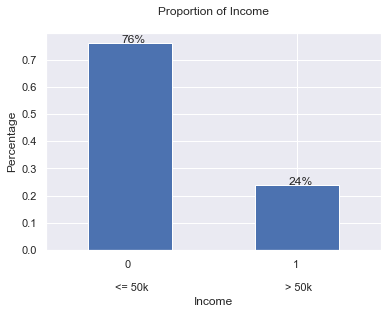

In [7]:
df['income'].value_counts(normalize=True).plot(kind='bar')
plt.title('Proportion of Income\n')
plt.ylabel('Percentage')
plt.xticks(ticks = [0,1], labels=['0 \n\n <= 50k','1 \n\n > 50k'], rotation=0)
plt.annotate('76%', (-0.05, 0.76) )
plt.annotate('24%', (0.95, 0.24) )
plt.xlabel('Income');

Let's explore the relation between our features and target variable income

### Numerical

In [8]:
print(num_list)

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']


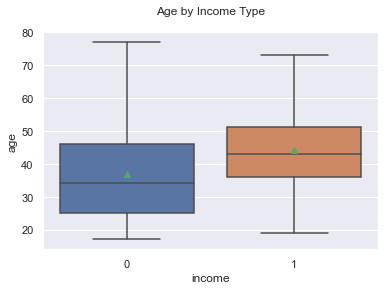

In [9]:
sns.boxplot(data=df, x='income', y='age', showfliers=False, showmeans=True)
plt.title('Age by Income Type\n');

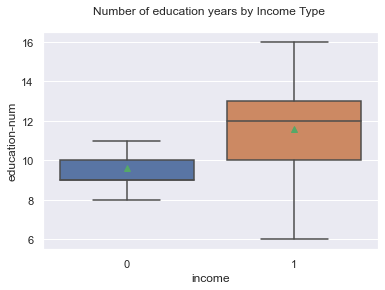

In [10]:
sns.boxplot(data=df, x='income', y='education-num', showfliers=False, showmeans=True)
plt.title('Number of education years by Income Type \n');

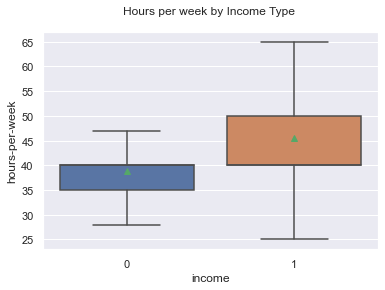

In [11]:
sns.boxplot(data=df, x='income', y='hours-per-week', showfliers=False, showmeans=True)
plt.title('Hours per week by Income Type \n');

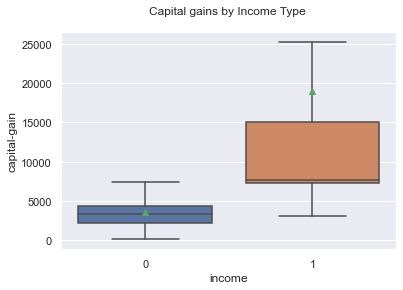

In [12]:
# For capital gains we're subsetting for capital gains above 0
sns.boxplot(data=df[df['capital-gain'] > 0], x='income', y='capital-gain', showfliers=False, showmeans=True)
plt.title('Capital gains by Income Type \n');

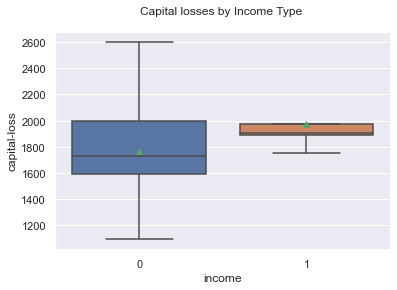

In [13]:
# For capital losses we're subsetting for capital losses above 0
sns.boxplot(data=df[df['capital-loss'] > 0], x='income', y='capital-loss', showfliers=False, showmeans=True)
plt.title('Capital losses by Income Type \n');

### Categorical
<br>For better visibility and customization, we'll plot them individually

In [14]:
print(cat_list)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [15]:
sns.set(rc={'figure.figsize':(7,5)})

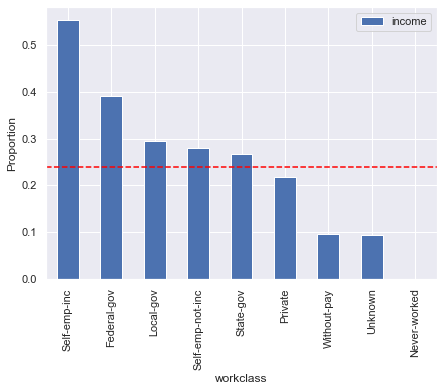

<Figure size 288x288 with 0 Axes>

In [16]:
df[['workclass','income']].groupby('workclass').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion')
plt.figure(figsize=(4,4));

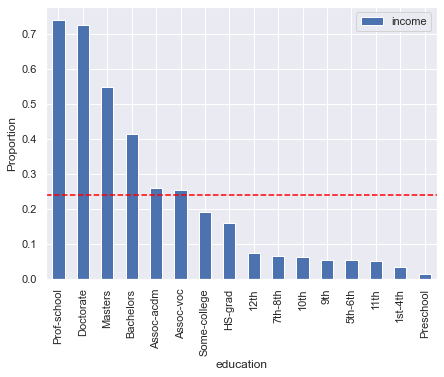

In [17]:
df[['education','income']].groupby('education').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion');

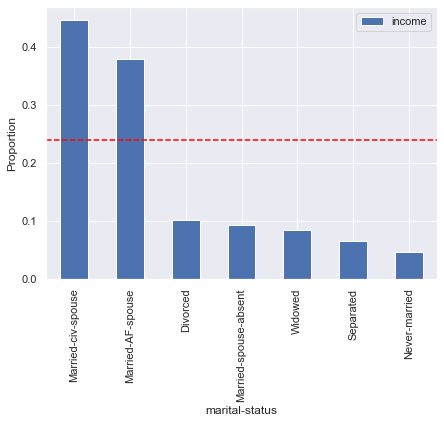

In [18]:
df[['marital-status','income']].groupby('marital-status').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion');

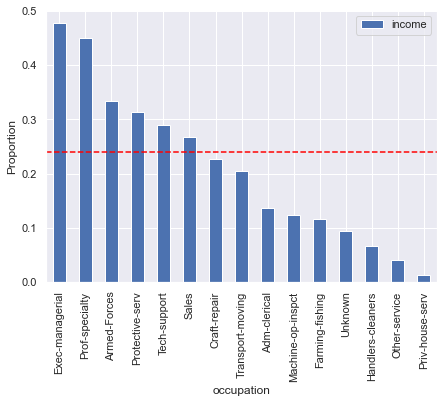

In [19]:
df[['occupation','income']].groupby('occupation').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion');

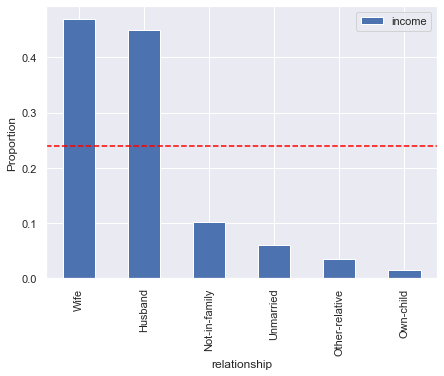

In [20]:
df[['relationship','income']].groupby('relationship').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion');

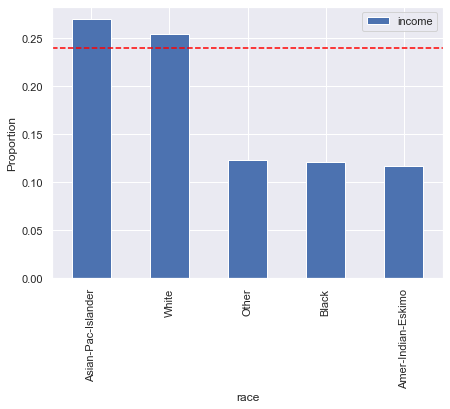

In [21]:
df[['race','income']].groupby('race').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion');

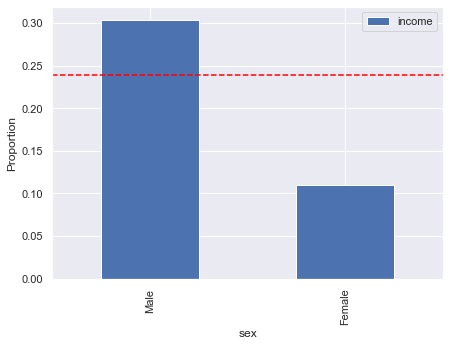

In [22]:
df[['sex','income']].groupby('sex').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion');

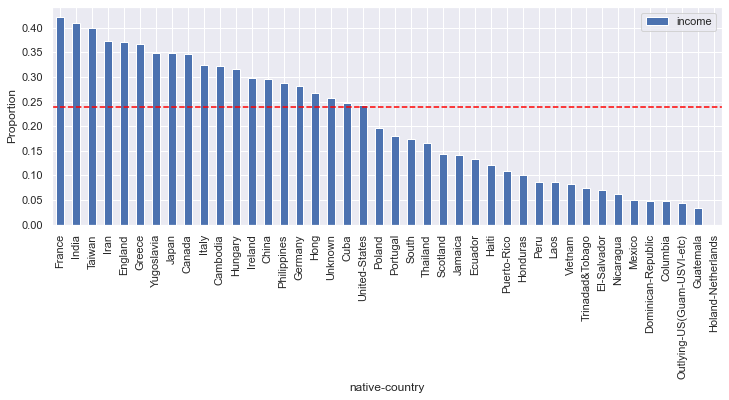

In [23]:
sns.set(rc={"figure.figsize":(12, 4)}) 
df[['native-country','income']].groupby('native-country').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion');

### Adding 2 additional features (bucketing for age and hours-per-week)

In [24]:
age_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
df['age_range'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

In [25]:
hours_bins = [0, 15, 25, 46, 100]
hours_labels = ['flexible', 'part-time', 'full-time', 'overtime']
df['work_schedule'] = pd.cut(df['hours-per-week'], bins=hours_bins, labels=hours_labels)

In [26]:
df.head(3)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_range,work_schedule
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,30-40,full-time
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,40-50,flexible
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,30-40,full-time


In [27]:
sns.set(rc={'figure.figsize':(7,5)})

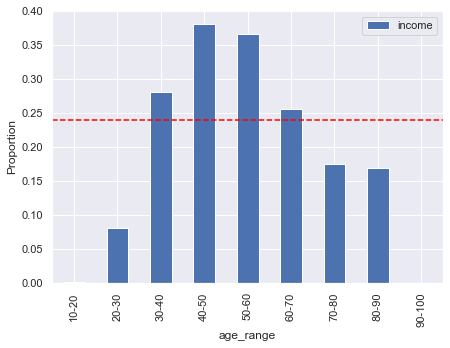

In [28]:
df[['age_range','income']].groupby('age_range').mean().plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion');

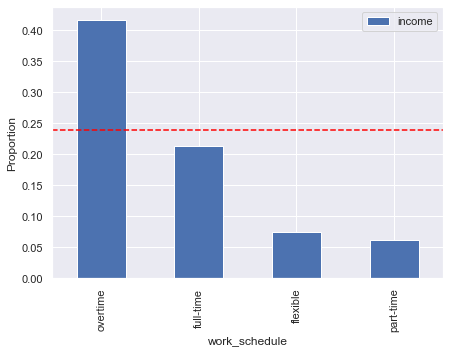

In [29]:
df[['work_schedule','income']].groupby('work_schedule').mean().sort_values(by = 'income', ascending=False).plot(kind="bar")
plt.axhline(df.income.mean(), color="red", linestyle = '--')
plt.ylabel('Proportion');

### Correlation heatmap for numerical vs target

<AxesSubplot:>

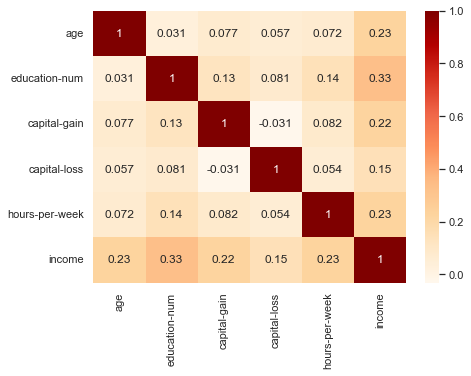

In [30]:
# plotting correlation heatmap for numerical variables
sns.heatmap(df[num_list].corr(), cmap='OrRd', annot=True)

### Correlation for categorical vs target

Since we can't get correlation between categorical variables, we'll use this function for Cramers V

In [31]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [32]:
# Adding 2 new columns to cat_list
cat_list.extend(('age_range','work_schedule'))

In [33]:
# Saving values for each category in a dictionary

corr_cat_dict = {}

for cat in cat_list:
    corr_cat_dict[cat] = cramers_v(df[cat], df['income'])

corr_cat_dict

{'workclass': 0.18115107631207908,
 'education': 0.3654521366236938,
 'marital-status': 0.4481697711621431,
 'occupation': 0.34959439912635987,
 'relationship': 0.45437891144289516,
 'race': 0.09944731744509899,
 'sex': 0.21453154666546925,
 'native-country': 0.09175910125047917,
 'age_range': 0.3080983838642458,
 'work_schedule': 0.24460695588806117}

In [34]:
# Converting to a dataframe to sort the values
df_corr_cat = pd.DataFrame.from_dict(corr_cat_dict, orient='index')
df_corr_cat.columns=['income']
df_corr_cat.sort_values('income', ascending=False)

,income
relationship,0.454379
marital-status,0.448170
education,0.365452
occupation,0.349594
age_range,0.308098
work_schedule,0.244607
sex,0.214532
workclass,0.181151
race,0.099447
native-country,0.091759


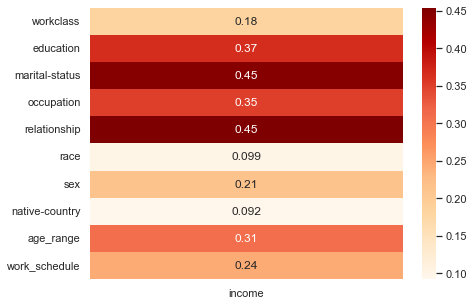

In [35]:
sns.heatmap(df_corr_cat, cmap='OrRd', annot=True);

### Encoding categorical columns

We'll encode the categorical columns in preparation for a Random Forest basic model we'll do to get feature importances. I tried using pandas get_dummies, but ended up with more than 100 columns which will not be easy for getting feature importance.

In [36]:
# Making a copy of our dataframe
df_encoded = df.copy()

In [37]:
# Creating an Ordinal Encoder instance
enc = OrdinalEncoder()

In [38]:
df_encoded[cat_list] = enc.fit_transform(df_encoded[cat_list])

In [39]:
df_encoded.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_range,work_schedule
0,39,6.0,9.0,13,4.0,0.0,1.0,4.0,1.0,2174,0,40,38.0,0,2.0,1.0
1,50,5.0,9.0,13,2.0,3.0,0.0,4.0,1.0,0,0,13,38.0,0,3.0,0.0
2,38,3.0,11.0,9,0.0,5.0,1.0,4.0,1.0,0,0,40,38.0,0,2.0,1.0
3,53,3.0,1.0,7,2.0,5.0,0.0,2.0,1.0,0,0,40,38.0,0,4.0,1.0
4,28,3.0,9.0,13,2.0,9.0,5.0,2.0,0.0,0,0,40,4.0,0,1.0,1.0


We can see now that our categorical features have been encoded

### Train/Test split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns='income'),  
                                                    df_encoded.income, test_size=0.3, 
                                                    random_state=42)

In [41]:
X_train.shape, X_test.shape

((34189, 15), (14653, 15))

In [42]:
y_train.shape, y_test.shape

((34189,), (14653,))

### Random Forest model

We're creating a basic Random Forest model to get the feature importances of the model. Then we can compare with our findings from the visualizations.

In [43]:
rf_clf = RandomForestClassifier(random_state=42)

In [44]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [45]:
rf_clf.feature_importances_

array([0.17201936, 0.0517963 , 0.03839791, 0.09546929, 0.07683132,
       0.08992875, 0.10418564, 0.01781021, 0.01410491, 0.12645578,
       0.04066485, 0.09105064, 0.02366458, 0.04345221, 0.01416825])

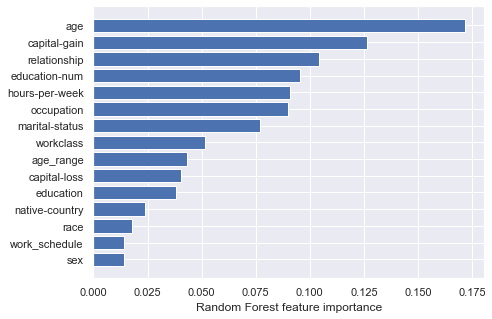

In [46]:
sorted_idx = rf_clf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf_clf.feature_importances_[sorted_idx])
plt.xlabel('Random Forest feature importance');

In [47]:
# Cross validating to know the accuracy of the basic model
cv_results = cross_validate(rf_clf, X_train, y_train, cv=5)

In [48]:
np.mean(cv_results['test_score'])

0.8494253370690071